File to train the deep learning model on new data

In [1]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode 

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import random

In [39]:
def cv2_imshow(im, rgb=False):
    if rgb:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off')

In [4]:
image_training_dir = "Images/pool/training/images/"
image_testing_dir = "Images/pool/testing/images/"
annotation_training_dir = "Images/pool/training/labels/"
annotation_testing_dir = "Images/pool/testing/labels/"
annotation_training_files = ["000002764.xml", "000002041.xml", "000000186.xml"]

In [5]:
# Parse XML file
def parse_xml(img_dir, file):
    tree = ET.parse(file)
    root = tree.getroot()

    file_dict = {}

    file_dict["file_name"] = os.path.join(img_dir.replace('labels', 'images'), root.find('filename').text)
    file_dict["height"] = int(root.find("size/height").text)
    file_dict["width"] = int(root.find("size/width").text)

    list_with_all_boxes = []
    for boxes in root.iter('object'):
        
        
        ymin, xmin, ymax, xmax = None, None, None, None
        
        ymin = round(float(boxes.find("bndbox/ymin").text))
        xmin = round(float(boxes.find("bndbox/xmin").text))
        ymax = round(float(boxes.find("bndbox/ymax").text))
        xmax = round(float(boxes.find("bndbox/xmax").text))

        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        list_with_all_boxes.append(obj)
    file_dict["annotations"] = list_with_all_boxes
    return file_dict

def parse_dir_xml(annotation_folder):
    fichiers = [f for f in os.listdir(annotation_folder) if os.path.isfile(os.path.join(annotation_folder, f))]
    dataset_dicts = []

    for data in fichiers:
        record = parse_xml(annotation_folder ,os.path.join(annotation_folder, data))
        dataset_dicts.append(record)
    return dataset_dicts

# Visualize image with bounding boxes
def visualize_image(image_folder, annotation_folder, annotation_file):
    data = parse_xml(annotation_folder, os.path.join(annotation_folder, annotation_file))

    img = cv2.imread(data["file_name"])

    for box in data["annotations"]:
        cv2.rectangle(img, (box["bbox"][0], box["bbox"][1]), (box["bbox"][2], box["bbox"][3]), (0, 255, 0), 2)
    
    cv2_imshow(img)

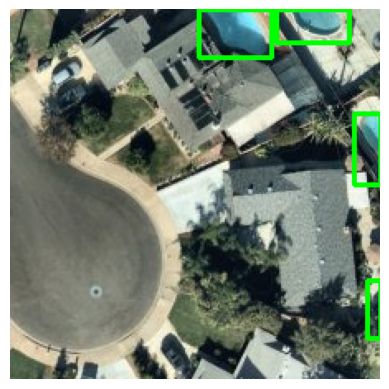

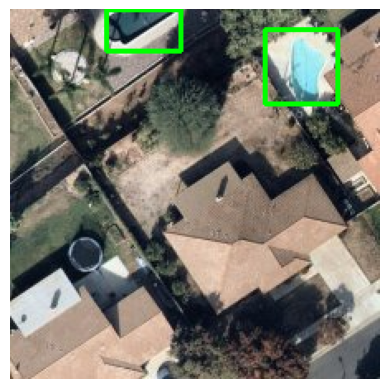

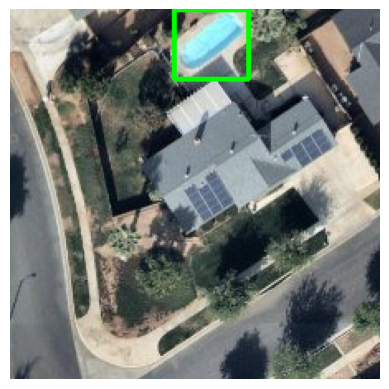

In [6]:
for ann_file in annotation_training_files:
    visualize_image(image_training_dir, annotation_training_dir, ann_file)

In [7]:
for d in ["training", "testing"]:
    DatasetCatalog.register("pool_" + d, lambda d=d: parse_dir_xml("Images/pool/" + d + "/labels/"))
    MetadataCatalog.get("pool_" + d).set(thing_classes=["pool"])

pool_metadata = MetadataCatalog.get("pool_training")

In [8]:
DatasetCatalog.get("pool_testing")

[{'file_name': 'Images/pool/testing/images/000000698.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [210, 204, 223, 224],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000524.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [77, 191, 128, 214],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000084.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 182, 20, 220],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000075.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 91, 18, 116],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000642.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 119, 48, 143],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'c

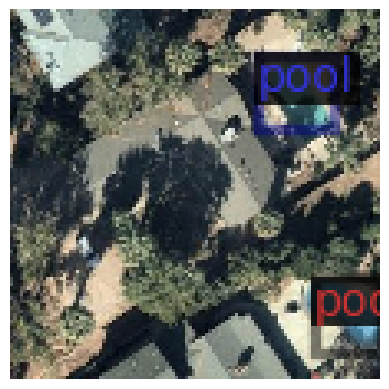

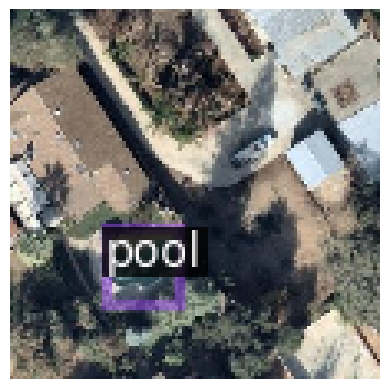

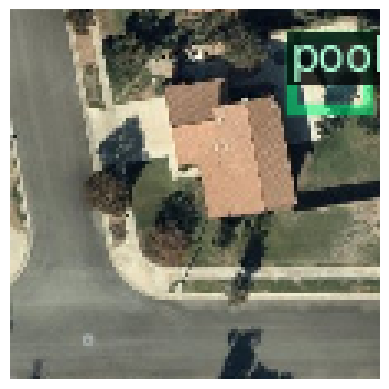

In [9]:
dataset_dicts = parse_dir_xml(annotation_training_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pool_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("pool_training")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/14 11:47:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[11/14 11:47:21 d2.engine.train_loop]: Starting training from iteration 0


/home/loicchamberlin/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/14 11:47:27 d2.utils.events]:  eta: 0:02:24  iter: 19  total_loss: 1.191  loss_cls: 0.7085  loss_box_reg: 0.3249  loss_rpn_cls: 0.1343  loss_rpn_loc: 0.006205    time: 0.2510  last_time: 0.2357  data_time: 0.0070  last_data_time: 0.0031   lr: 8.1588e-06  max_mem: 2854M
[11/14 11:47:32 d2.utils.events]:  eta: 0:02:13  iter: 39  total_loss: 1.035  loss_cls: 0.5961  loss_box_reg: 0.2986  loss_rpn_cls: 0.1621  loss_rpn_loc: 0.008039    time: 0.2421  last_time: 0.2419  data_time: 0.0035  last_data_time: 0.0028   lr: 1.6484e-05  max_mem: 2856M
[11/14 11:47:36 d2.utils.events]:  eta: 0:02:07  iter: 59  total_loss: 0.8362  loss_cls: 0.4299  loss_box_reg: 0.3287  loss_rpn_cls: 0.1132  loss_rpn_loc: 0.009397    time: 0.2393  last_time: 0.2319  data_time: 0.0032  last_data_time: 0.0032   lr: 2.4809e-05  max_mem: 2856M
[11/14 11:47:41 d2.utils.events]:  eta: 0:02:02  iter: 79  total_loss: 0.7956  loss_cls: 0.3373  loss_box_reg: 0.3234  loss_rpn_cls: 0.09703  loss_rpn_loc: 0.008441    time: 0.2

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

[11/14 11:49:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Images/pool/testing/images/000000271.jpg
Images/pool/testing/images/000000047.jpg
Images/pool/testing/images/000000138.jpg
Images/pool/testing/images/000000983.jpg


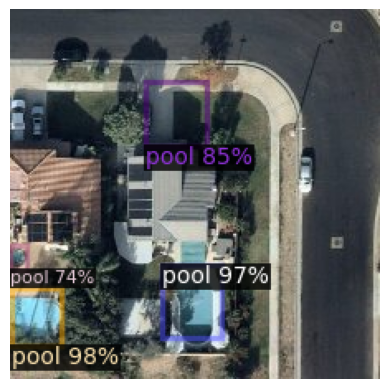

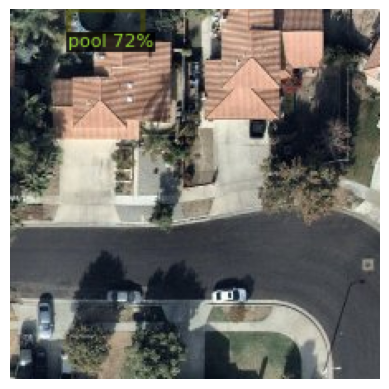

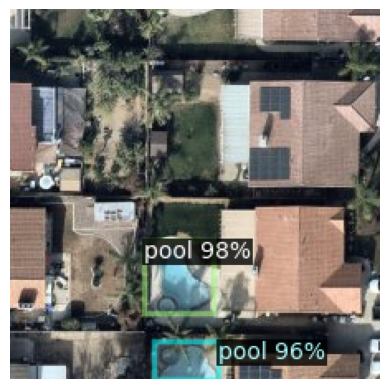

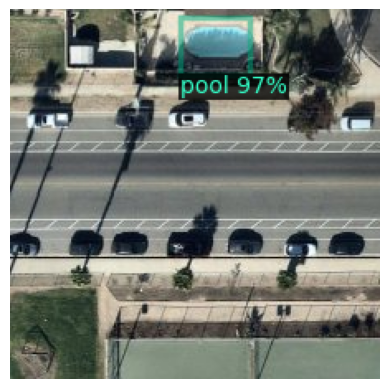

In [13]:
from detectron2.utils.visualizer import ColorMode
# from detectron2.utils.visualizer import ColorMode
dataset_dicts2 = parse_dir_xml("Images/pool/testing/labels/")
dataset_dicts2
for d in random.sample(dataset_dicts2, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=pool_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1])


In [43]:
im = cv2.imread("Images/pool/testing/image_cropped/img_x0_y0.jpg")
img_z = np.ones((224,224,3)) 
img_z[:,:,2] =  im[:,:,2]
output = predictor(img_z)
print(output)

{'instances': Instances(num_instances=0, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}


In [58]:
print(img_z)

[[[  1.   1. 178.]
  [  1.   1. 126.]
  [  1.   1. 133.]
  ...
  [  1.   1. 126.]
  [  1.   1. 157.]
  [  1.   1. 152.]]

 [[  1.   1. 154.]
  [  1.   1. 118.]
  [  1.   1. 129.]
  ...
  [  1.   1. 161.]
  [  1.   1. 166.]
  [  1.   1. 162.]]

 [[  1.   1. 131.]
  [  1.   1. 116.]
  [  1.   1. 130.]
  ...
  [  1.   1. 164.]
  [  1.   1. 155.]
  [  1.   1. 153.]]

 ...

 [[  1.   1.  87.]
  [  1.   1.  94.]
  [  1.   1.  94.]
  ...
  [  1.   1.  89.]
  [  1.   1.  76.]
  [  1.   1.  64.]]

 [[  1.   1. 117.]
  [  1.   1. 113.]
  [  1.   1. 102.]
  ...
  [  1.   1.  79.]
  [  1.   1.  77.]
  [  1.   1.  68.]]

 [[  1.   1. 127.]
  [  1.   1. 124.]
  [  1.   1. 126.]
  ...
  [  1.   1.  66.]
  [  1.   1.  69.]
  [  1.   1.  76.]]]


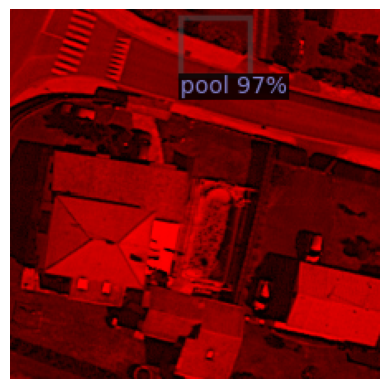

In [60]:
v = Visualizer(img_z,
                metadata=pool_metadata, 
                scale=1, 
                # instance_mode=ColorMode.IMAGE  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:,:, ::-1])